<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Importance

---

## Learning Objectives

### Core
- Describe the concept of feature importance
- Explain how we can identify relative feature importance in linear regression and tree-based models
- Extract feature importance with scikit-learn

### Target
- Calculate the information gain result from a given decision tree split

### Stretch
- Calculate the feature importance manually from the information about all the decision tree splits


### Lesson Guide
- [Introduction to feature importance](#introduction-to-feature-importance)
- [Feature importance in models](#feature-importance-in-models)
	- [Feature importance in linear models](#feature-importance-in-linear-models)
	- [Feature importance in decision trees](#feature-importance-in-decision-trees)
	- [Demo: Feature importance in a decision tree](#demo-feature-importance-in-a-decision-tree)
- [What happens if our features are highly correlated?](#what-happens-if-our-features-are-highly-correlated)
- [Additional resources](#additional-resources)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

np.set_printoptions(precision=4)

This notebook uses pydot and graphviz as dependencies which are often not installed by default. You can install them using:
> conda install graphviz

> conda install pydotplus

<a id="introduction-to-feature-importance"></a>
## Introduction to feature importance
---

When we build a machine learning model, we may be interested in more than just predictive accuracy.

Often we are seeking insights on the relevant predictor variables.

E.g. you have 1000 features to predict user retention.
Which features are relevant? Can you identify them? Can you build marketing strategies to address them?

<a id="feature-importance-in-models"></a>
## Feature importance in models

<a id="feature-importance-in-linear-models"></a>
### Feature importance in linear models

Logistic regression is a *parametric model*, which means that our model is described by an assumed structure (and equation) which has parameters that we tune to improve the model's accuracy. Since Logistic regression is a linear model, each parameter is associated with a specific feature.

If the features are normalized, we can interpret the magnitude of each coefficient as indicating the relative importance of that specific feature. (The precise interpretation depends on how you've set up your model.)

<a id="feature-importance-in-decision-trees"></a>
### Feature importance in decision trees
Tree based models are non-parametric, thus we don't have coefficients to tune like we did in linear models.

**However, we can  still ask which of the features are more important.**

When training a tree, we can compute how much each feature decreases the weighted impurity by adding up all the purity gains where such a feature is used to determine a split.

So the importance of a feature is computed as the (normalized) total reduction of the impurity brought by that feature. 

<a id="demo-feature-importance-in-a-decision-tree"></a>
### Demo: Feature importance in a decision tree

Suppose you are working at a car company and you are tasked to identify which features drive the acceptability of a car. You have collected some data on several features.


**Feature values are:**

    buying       v-high, high, med, low
    maint        v-high, high, med, low
    doors        2, 3, 4, 5-more
    persons      2, 4, more
    lug_boot     small, med, big
    safety       low, med, high

**Class Distribution (number of instances per class):**

    class      N          N[%]
    -----------------------------
    unacc     1210     (70.023 %) 
    acc        384     (22.222 %) 
    good        69     ( 3.993 %) 
    v-good      65     ( 3.762 %) 

First, load the features and map them to binary features.

In [2]:
df = pd.read_csv('../../../../resource-datasets/car_evaluation/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a one hot encoding scheme, i.e. we will consider them as categorical variables.


In [3]:
y = df.pop('acceptability')
X = pd.get_dummies(df, drop_first=True)
y.value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: acceptability, dtype: int64

In [4]:
X.shape

(1728, 15)

In [5]:
X.columns

Index(['buying_low', 'buying_med', 'buying_vhigh', 'maint_low', 'maint_med',
       'maint_vhigh', 'doors_3', 'doors_4', 'doors_5more', 'persons_4',
       'persons_more', 'lug_boot_med', 'lug_boot_small', 'safety_low',
       'safety_med'],
      dtype='object')

Train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [6]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=3, min_samples_split=2, random_state=1)  # Keep it shallow

dt.fit(X, y)

print(dt.classes_)

['acc' 'good' 'unacc' 'vgood']


Let's visualize the tree using graphviz

In [7]:
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,
                feature_names=X.columns,  
                class_names=dt.classes_,
                filled=True, rounded=True,
                proportion=True,
                special_characters=True,
                node_ids=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

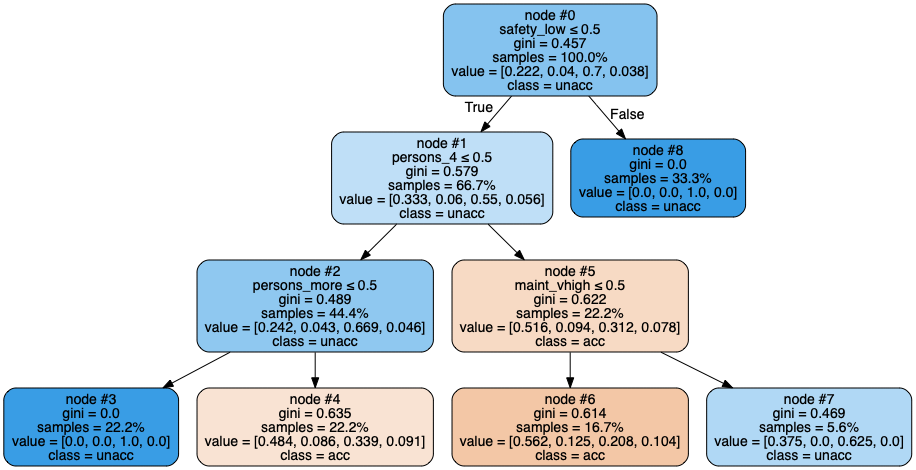

In [8]:
Image(graph.create_png())

#### Calculate the feature importance

The first split involves `safety_low`. If safety is low (`safety_low` == 1) then the condition (our target class) is `unacceptable`. This happens in 33% of the cases. Note that the leaf under the `False` branch is 100% pure, and therefore its Gini measure is 0.0.

On the other hand, if the car has medium or high safety, we will need to consider other choices. 

Recall the equation for Gini:

$$
\text{Gini}(t) = 1 - \sum_{i=0}^{c} [p(i|t)]^2
$$

where 

$$ p(i|t) $$

is just the proportion of records that belong to class _i_ at a given node _t_.

This equation holds true for any number of classes, not just binary classification.  So we can use it here where we have four classes.

As a reminder, let's plot the gini index for various proportions in a binary classification:

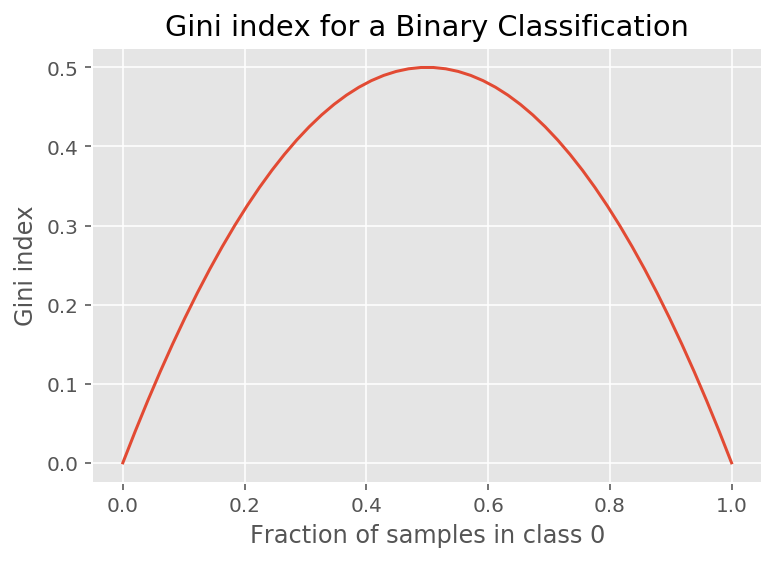

In [9]:
C0 = np.linspace(0, 1)
C1 = 1.0 - C0
# Because it's binary, you can't do worse than .50
gini = 1 - (C0**2 + C1**2)

plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification')
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')
plt.show()

The Gini index takes a value of 0 for total purity (one class represented), and takes its maximum value when all the classes are equally represented (in the case of a binary classifier, this value is 0.5, but it varies with the number of classes).

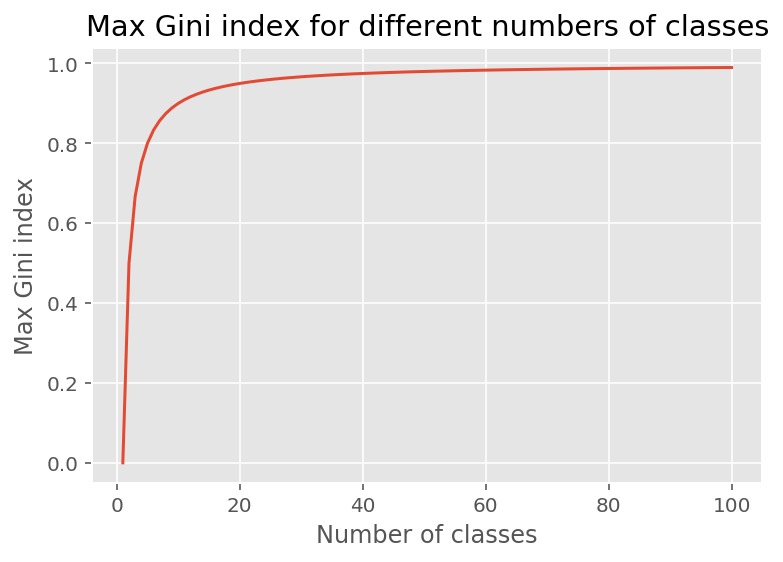

In [10]:
gini_list = []

for i in range(1, 101):
    gini = 1 - i*(1.0/i)**2
    gini_list.append(gini)
    
plt.plot(list(range(1, 101)), gini_list)
plt.title('Max Gini index for different numbers of classes')
plt.xlabel('Number of classes')
plt.ylabel('Max Gini index')
plt.show()

#### Back to our example

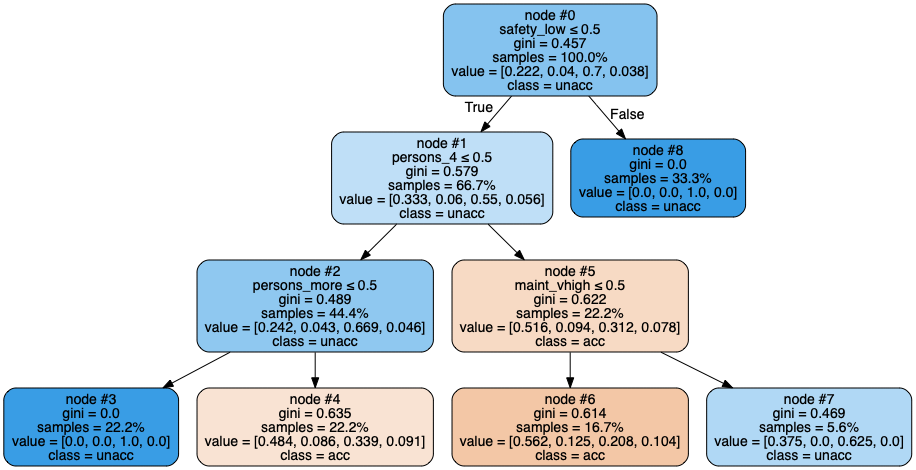

In [11]:
Image(graph.create_png())

Let's verify the calculation of the Gini index in the root node of the tree above:

In [12]:
root_node_values = [0.222, 0.04, 0.7, 0.038]


def gini(values):
    tot = 1.0
    for val in values:
        tot -= val ** 2
    return tot


gini(root_node_values)

0.457672

Great, now we are ready to look at feature importances in our tree.

Remember: the importance of a feature is computed as the (normalized) total reduction of the impurity brought by that feature. 

We can calculate this in sklearn.

In [13]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head()

,importance
persons_more,0.406897
safety_low,0.378680
persons_4,0.162238
maint_vhigh,0.052185
buying_low,0.000000


Since we artificially constricted the tree to be small, only 3 features are used to make splits. Let's verify the calculation of the importance.

In [14]:
gini_gain_1 = 1.0 * 0.457 - 0.667 * 0.579 - 0.333 * 0.0
gini_gain_2 = 0.667 * 0.579 - 0.444 * 0.489 - 0.222 * 0.635
gini_gain_3 = 0.444 * 0.489 - 0.222 * 0 - 0.222 * 0.635
gini_gain_4 = 0.222 * 0.622 - 0.167 * 0.614 - 0.056 * 0.469

# Calc total decrease in node impurity, weighted by prob of reaching that node (i.e. % of samples there)
total_gain = gini_gain_1 + gini_gain_2 + gini_gain_3 + gini_gain_4

print(round(gini_gain_1 / total_gain, 3))
print(round(gini_gain_2 / total_gain, 3))
print(round(gini_gain_3 / total_gain, 3))
print(round(gini_gain_4 / total_gain, 3))

0.384
0.152
0.413
0.05


Note that feature importance depends on purity gain and number of samples at that node. Features that appear higher in the tree tend to have greater importance.

Of course, getting these numbers by hand is not what you really should do.

The tree attributes are stored here:

In [15]:
dt.tree_.__getstate__()

{'max_depth': 3,
 'node_count': 9,
 'nodes': array([( 1,  8, 13,  0.5, 0.4573, 1728, 1728.),
        ( 2,  5,  9,  0.5, 0.5792, 1152, 1152.),
        ( 3,  4, 10,  0.5, 0.4895,  768,  768.),
        (-1, -1, -2, -2. , 0.    ,  384,  384.),
        (-1, -1, -2, -2. , 0.6351,  384,  384.),
        ( 6,  7,  5,  0.5, 0.6216,  384,  384.),
        (-1, -1, -2, -2. , 0.6137,  288,  288.),
        (-1, -1, -2, -2. , 0.4688,   96,   96.),
        (-1, -1, -2, -2. , 0.    ,  576,  576.)],
       dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]),
 'values': array([[[ 384.,   69., 1210.,   65.]],
 
        [[ 384.,   69.,  634.,   65.]],
 
        [[ 186.,   33.,  514.,   35.]],
 
        [[   0.,    0.,  384.,    0.]],
 
        [[ 186.,   33.,  130.,   35.]],
 
        [[ 198.,   36.,  120.,   30.]],
 
        [[ 162.,   36.,   60.,   30.]],
 
        [[  36.,    0

The entry about the nodes denotes for node `i` in row `i`

- the left and right child nodes (index 0 and 1): in this case 1 and 8 (Note -1 means no child nodes),
- the feature used in the split (index 2): in this case 13 (ie, safety),
- the decision threshold (index 3): in this case 0.5 was threshold used,
- the impurity for each node (index 4): the gini at that node in this case 0.4573,
- the number of samples in the node

We extract the node attributes with:

In [16]:
tree_state = dt.tree_.__getstate__()['nodes']
print(tree_state)

[( 1,  8, 13,  0.5, 0.4573, 1728, 1728.)
 ( 2,  5,  9,  0.5, 0.5792, 1152, 1152.)
 ( 3,  4, 10,  0.5, 0.4895,  768,  768.)
 (-1, -1, -2, -2. , 0.    ,  384,  384.)
 (-1, -1, -2, -2. , 0.6351,  384,  384.)
 ( 6,  7,  5,  0.5, 0.6216,  384,  384.)
 (-1, -1, -2, -2. , 0.6137,  288,  288.)
 (-1, -1, -2, -2. , 0.4688,   96,   96.)
 (-1, -1, -2, -2. , 0.    ,  576,  576.)]


We extract the representatives of each class in each node with:

In [17]:
[dt.tree_.value[i]/dt.tree_.value[i].sum() for i in range(len(dt.tree_.value))]

[array([[0.2222, 0.0399, 0.7002, 0.0376]]),
 array([[0.3333, 0.0599, 0.5503, 0.0564]]),
 array([[0.2422, 0.043 , 0.6693, 0.0456]]),
 array([[0., 0., 1., 0.]]),
 array([[0.4844, 0.0859, 0.3385, 0.0911]]),
 array([[0.5156, 0.0938, 0.3125, 0.0781]]),
 array([[0.5625, 0.125 , 0.2083, 0.1042]]),
 array([[0.375, 0.   , 0.625, 0.   ]]),
 array([[0., 0., 1., 0.]])]

Repeat the feature importance calculation extracting the exact values:

In [18]:
observations = len(X)
importances = {}
nodes_with_childnodes = [i for i, state in enumerate(tree_state) if state[0] >= 0]

for i in nodes_with_childnodes:
    
    parent = tree_state[i]
    left_child = tree_state[parent[0]]
    right_child = tree_state[parent[1]]
    
    parent_importance = parent[4]*parent[5]/observations
    left_child_importance = left_child[4]*left_child[5]/observations
    right_child_importance = right_child[4]*right_child[5]/observations
    
    importances[i] = parent_importance - left_child_importance - right_child_importance

[imp/sum(importances.values()) for imp in list(importances.values())]

[0.3786798989392903,
 0.16223827718948505,
 0.4068968406938745,
 0.05218498317735019]

In [19]:
print(dt.feature_importances_)

[0.     0.     0.     0.     0.     0.0522 0.     0.     0.     0.1622
 0.4069 0.     0.     0.3787 0.    ]


Now we reproduced the results exactly.

#### Write a function that calculates the importance of each feature from the `tree_state` above. Generalize to decision trees with higher depth. Compare to the sklearn result. What are the results if you choose entropy instead of Gini?

<a id="guided-practice-feature-importance-in-ensemble-models--min"></a>

<a id="what-happens-if-our-features-are-highly-correlated"></a>
## What happens if our features are highly correlated?
---

Word of warning with respect to interpretations:

If we have two highly correlated features, our model could split on either to achieve the same effect. However, once it has split on one of the features, the power of the other is greatly reduced because the purity gain has been realized. So the second feature may show up with no importance.

This may cause problems with interpretation if one of the features has no causal effect, but is correlated with a feature that does have a causal effect.


<a id="additional-resources"></a>
## Additional resources
---

- [Gini Importance](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp)
- [DT Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Feature Importance in Sklearn Blog](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/)
- [Plot Feature Importances example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- [Selecting good features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
- [Explore a decision tree built with sklearn](https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn)